# 通过微调进行迁移学习
前面我们介绍了如何训练卷积神经网络进行图像分类，可能你已经注意到了，训练一个卷积网络是特别耗费时间的，特别是一个比较深的卷积网络，而且可能因为训练方法不当导致训练不收敛的问题，就算训练好了网络，还有可能出现过拟合的问题，所以由此可见能够得到一个好的模型有多么困难。

有的时候，我们的数据集还特别少，这对于我们来讲无异于雪上加霜，因为少的数据集意味着非常高的风险过拟合，那么我们有没有办法在某种程度上避免这个问题呢？其实现在有一种方法特别流行，大家一直在使用，那就是微调(fine-tuning)，在介绍微调之前，我们先介绍一个数据集 ImageNet。

## ImageNet
ImageNet 是一个计算机视觉系统识别项目，是目前世界上最大的图像识别数据库，由斯坦福大学组织建立，大约有 1500 万张图片，2.2 万中类别，其中 ISLVRC 作为其子集是学术界中使用最为广泛的公开数据集，一共有 1281167 张图片作为训练集，50000 张图片作为验证集，一共是 1000 分类，是目前测试网络性能的标杆。

我们说的这个数据集有什么用呢？我们又不关心这个数据集，但是对于我们自己的问题，我们有没有办法借助 ImageNet 中的数据集来提升模型效果，比如我们要做一个猫狗分类器，但是我们现在只有几百张图片，肯定不够，ImageNet 中有很多关于猫狗的图片，我们如果能够把这些图片拿过来训练，不就能够提升模型性能了吗？

但是这种做法太麻烦了，从 ImageNet 中寻找这些图片就很困难，如果做另外一个问题又要去找新的图片，所以直接找图片并不靠谱，那么有没有办法能够让我们不去找这些图片，又能使用这些图片呢？

非常简单，我们可以使用在 ImageNet 上训练好的网路，然后把这个网络在放到我们自己的数据集上进行训练不就好了。这个方法就叫做微调，这十分形象，相当于把一个已经很厉害的模型再微调到我们自己的数据集上来，也可称为迁移学习。

迁移学习的方法非常简单，将预训练的模型导入，然后将最后的分类全连接层换成适合我们自己问题的全连接层，然后开始训练，可以固定卷积层的参数，也可以不固定进行训练，最后能够非常有效的得到结果

pytorch 一直为我们内置了前面我们讲过的那些著名网络的预训练模型，不需要我们自己去 ImageNet 上训练了，模型都在 `torchvision.models` 里面，比如我们想使用预训练的 50 层 resnet，就可以用 `torchvision.models.resnet50(pretrained=True)` 来得到

下面我们用一个例子来演示一些微调

In [1]:
import sys
sys.path.append('..')

import numpy as np

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torchvision import models
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder

首先我们点击下面的[链接](https://download.pytorch.org/tutorial/hymenoptera_data.zip)获得数据集，终端可以使用

`wget https://download.pytorch.org/tutorial/hymenoptera_data.zip`

下载完成之后，我们将其解压放在程序的目录下，这是一个二分类问题，区分蚂蚁和蜜蜂

我们可以可视化一下图片，看看你能不能区分出他们来

In [14]:
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

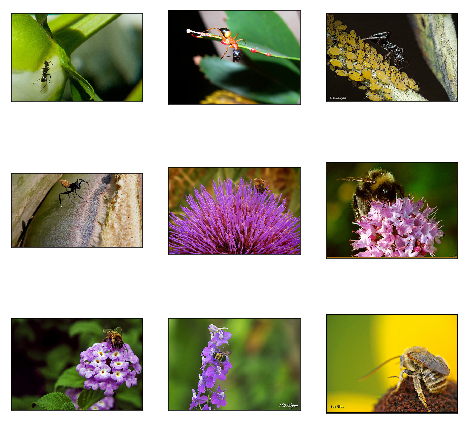

In [21]:
root_path = './hymenoptera_data/train/'
im_list = [os.path.join(root_path, 'ants', i) for i in os.listdir(root_path + 'ants')[:4]]
im_list += [os.path.join(root_path, 'bees', i) for i in os.listdir(root_path + 'bees')[:5]]

nrows = 3
ncols = 3
figsize = (8, 8)
_, figs = plt.subplots(nrows, ncols, figsize=figsize)
for i in range(nrows):
    for j in range(ncols):
        figs[i][j].imshow(Image.open(im_list[nrows*i+j]))
        figs[i][j].axes.get_xaxis().set_visible(False)
        figs[i][j].axes.get_yaxis().set_visible(False)
plt.show()

In [2]:
# 定义数据预处理
train_tf = tfs.Compose([
    tfs.RandomResizedCrop(224),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 使用 ImageNet 的均值和方差
])

valid_tf = tfs.Compose([
    tfs.Resize(256),
    tfs.CenterCrop(224),
    tfs.ToTensor(),
    tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# 使用 ImageFolder 定义数据集
train_set = ImageFolder('./hymenoptera_data/train/', train_tf)
valid_set = ImageFolder('./hymenoptera_data/val/', valid_tf)
# 使用 DataLoader 定义迭代器
train_data = DataLoader(train_set, 64, True, num_workers=4)
valid_data = DataLoader(valid_set, 128, False, num_workers=4)

In [13]:
# 使用预训练的模型
net = models.resnet50(pretrained=True)
print(net)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1):

In [14]:
# 打出第一层的权重
print(net.conv1.weight)

Parameter containing:
(0 ,0 ,.,.) = 
  1.3335e-02  1.4664e-02 -1.5351e-02  ...  -4.0896e-02 -4.3034e-02 -7.0755e-02
  4.1205e-03  5.8477e-03  1.4948e-02  ...   2.2060e-03 -2.0912e-02 -3.8517e-02
  2.2331e-02  2.3595e-02  1.6120e-02  ...   1.0281e-01  6.2641e-02  5.1977e-02
                 ...                   ⋱                   ...                
 -9.0349e-04  2.7767e-02 -1.0105e-02  ...  -1.2722e-01 -7.6604e-02  7.8453e-03
  3.5894e-03  4.8006e-02  6.2051e-02  ...   2.4267e-02 -3.3662e-02 -1.5709e-02
 -8.0029e-02 -3.2238e-02 -1.7808e-02  ...   3.5359e-02  2.2439e-02  1.7077e-03

(0 ,1 ,.,.) = 
 -1.8452e-02  1.1415e-02  2.3850e-02  ...   5.3736e-02  4.4022e-02 -9.4675e-03
 -7.7273e-03  1.8890e-02  6.7981e-02  ...   1.5956e-01  1.4606e-01  1.1999e-01
 -4.6013e-02 -7.6075e-02 -8.9648e-02  ...   1.2108e-01  1.6705e-01  1.7619e-01
                 ...                   ⋱                   ...                
  2.8818e-02  1.3665e-02 -8.3825e-02  ...  -3.8081e-01 -3.0414e-01 -1.3966e-01

In [15]:
# 将最后的全连接层改成二分类
net.fc = nn.Linear(2048, 2)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

In [17]:
from utils import train
train(net, train_data, valid_data, 20, optimizer, criterion)

Epoch 0. Train Loss: 0.627600, Train Acc: 0.624399, Valid Loss: 0.713161, Valid Acc: 0.483750, Time 00:00:02
Epoch 1. Train Loss: 0.534958, Train Acc: 0.663161, Valid Loss: 0.612412, Valid Acc: 0.650156, Time 00:00:03
Epoch 2. Train Loss: 0.354584, Train Acc: 0.899639, Valid Loss: 0.220221, Valid Acc: 0.940937, Time 00:00:03
Epoch 3. Train Loss: 0.296389, Train Acc: 0.927885, Valid Loss: 0.207770, Valid Acc: 0.956562, Time 00:00:03
Epoch 4. Train Loss: 0.251669, Train Acc: 0.941406, Valid Loss: 0.199639, Valid Acc: 0.960469, Time 00:00:03
Epoch 5. Train Loss: 0.200544, Train Acc: 0.963041, Valid Loss: 0.185101, Valid Acc: 0.960469, Time 00:00:03
Epoch 6. Train Loss: 0.228474, Train Acc: 0.930288, Valid Loss: 0.339473, Valid Acc: 0.892656, Time 00:00:03
Epoch 7. Train Loss: 0.207282, Train Acc: 0.921274, Valid Loss: 0.149510, Valid Acc: 0.940937, Time 00:00:03
Epoch 8. Train Loss: 0.167375, Train Acc: 0.960036, Valid Loss: 0.165911, Valid Acc: 0.956562, Time 00:00:03
Epoch 9. Train Loss

下面我们来可视化预测的结果

In [19]:
net = net.eval() # 将网络改为预测模式

读一张蚂蚁的图片

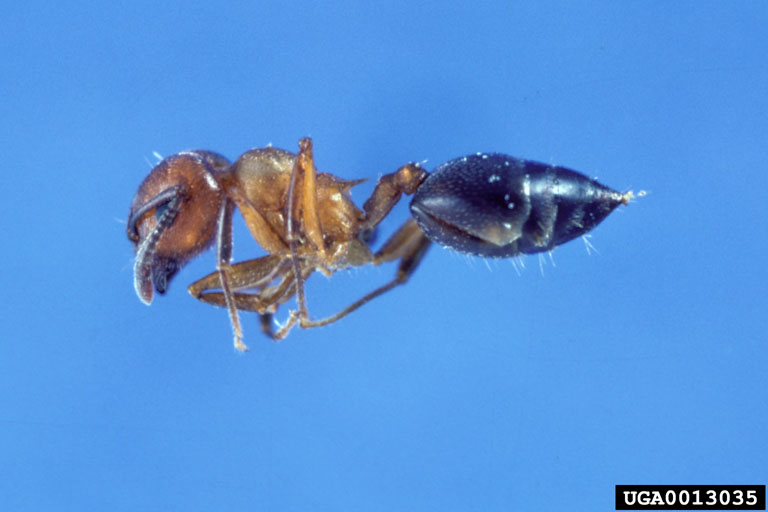

In [20]:
im1 = Image.open('./hymenoptera_data/train/ants/0013035.jpg')
im1

In [21]:
im = valid_tf(im1) # 做数据预处理
out = net(Variable(im.unsqueeze(0)).cuda())
pred_label = out.max(1)[1].data[0]
print('predict label: {}'.format(train_set.classes[pred_label]))

predict label: ants


可以看到预测的结果是对的

**小练习：看看上面的网络预测过程，多尝试几张图片进行预测**

In [8]:
# 保持前面的卷积层参数不变
net = models.resnet50(pretrained=True)
for param in net.parameters():
    param.requires_grad = False # 将模型的参数设置为不求梯度
net.fc = nn.Linear(2048, 2)

optimizer = torch.optim.SGD(net.fc.parameters(), lr=1e-2, weight_decay=1e-4)

In [12]:
train(net, train_data, valid_data, 20, optimizer, criterion)

Epoch 0. Train Loss: 0.619283, Train Acc: 0.677584, Valid Loss: 0.365831, Valid Acc: 0.808594, Time 00:00:02
Epoch 1. Train Loss: 0.476328, Train Acc: 0.835337, Valid Loss: 0.454169, Valid Acc: 0.808750, Time 00:00:02
Epoch 2. Train Loss: 0.423460, Train Acc: 0.863582, Valid Loss: 0.755112, Valid Acc: 0.538906, Time 00:00:02
Epoch 3. Train Loss: 0.382857, Train Acc: 0.856671, Valid Loss: 0.409471, Valid Acc: 0.788750, Time 00:00:02
Epoch 4. Train Loss: 0.337946, Train Acc: 0.913462, Valid Loss: 0.449115, Valid Acc: 0.784844, Time 00:00:02
Epoch 5. Train Loss: 0.341769, Train Acc: 0.880409, Valid Loss: 0.559394, Valid Acc: 0.705313, Time 00:00:02
Epoch 6. Train Loss: 0.326585, Train Acc: 0.851562, Valid Loss: 0.222567, Valid Acc: 0.933125, Time 00:00:02
Epoch 7. Train Loss: 0.263430, Train Acc: 0.924880, Valid Loss: 0.346770, Valid Acc: 0.808750, Time 00:00:02
Epoch 8. Train Loss: 0.308510, Train Acc: 0.876202, Valid Loss: 0.256893, Valid Acc: 0.940469, Time 00:00:02
Epoch 9. Train Loss

可以看到只训练验证集的准确率也可以达到比较高，但是 loss 跳动比较大，因为更新的参数太少了，只有全连接层的参数

In [12]:
# 不使用预训练的模型
net = models.resnet50()
net.fc = nn.Linear(2048, 2)

optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

In [13]:
# 打出第一层的权重
print(net.conv1.weight)

Parameter containing:
(0 ,0 ,.,.) = 
1.00000e-02 *
 -0.0567 -4.1588  0.0105  ...  -0.1119 -0.2745  0.5707
 -2.5873  2.2117  0.8934  ...  -0.1620 -1.5486 -1.9326
  2.9815  6.1294 -1.2279  ...  -0.3515 -4.8073 -2.1427
           ...             ⋱             ...          
 -4.3577  0.1747  3.2660  ...   5.8964 -0.7102 -0.5296
  1.7968 -0.6364  1.5020  ...   2.5407 -1.6381  1.6288
  0.9442  0.8170 -1.2126  ...  -2.0201 -1.0320  2.1268

(0 ,1 ,.,.) = 
1.00000e-02 *
  1.3832 -2.4412  0.9790  ...   0.3005  0.9213 -2.4297
 -0.3945 -2.3060 -0.9967  ...  -1.9593 -1.7380 -3.2350
 -1.9276 -1.3089  4.8536  ...   3.2571  4.6997  3.3420
           ...             ⋱             ...          
  0.0691 -2.5891 -3.4464  ...   2.8905 -2.2376  3.5079
 -4.7411 -0.2467 -4.0959  ...   0.3010 -2.1790 -2.0739
 -4.8234 -2.4718  1.8820  ...  -2.3377 -3.3540  2.8906

(0 ,2 ,.,.) = 
1.00000e-02 *
  2.6300  4.1233 -3.6107  ...   2.6179  4.1958 -1.1002
  1.1691 -2.1549 -1.4611  ...   0.4970 -2.0865  2.2103
 -2.4360 

In [9]:
train(net, train_data, valid_data, 20, optimizer, criterion)

Epoch 0. Train Loss: 2.607935, Train Acc: 0.485577, Valid Loss: 1.355199, Valid Acc: 0.726562, Time 00:00:01
Epoch 1. Train Loss: 2.598156, Train Acc: 0.560397, Valid Loss: 1.730986, Valid Acc: 0.273438, Time 00:00:03
Epoch 2. Train Loss: 2.768743, Train Acc: 0.520433, Valid Loss: 1.205057, Valid Acc: 0.273438, Time 00:00:03
Epoch 3. Train Loss: 2.541335, Train Acc: 0.489483, Valid Loss: 2.040526, Valid Acc: 0.273438, Time 00:00:03
Epoch 4. Train Loss: 1.286088, Train Acc: 0.576322, Valid Loss: 1.137075, Valid Acc: 0.309063, Time 00:00:03
Epoch 5. Train Loss: 1.081273, Train Acc: 0.528245, Valid Loss: 2.186767, Valid Acc: 0.277344, Time 00:00:03
Epoch 6. Train Loss: 1.001506, Train Acc: 0.529147, Valid Loss: 1.467141, Valid Acc: 0.380781, Time 00:00:03
Epoch 7. Train Loss: 0.850950, Train Acc: 0.618990, Valid Loss: 2.721868, Valid Acc: 0.273438, Time 00:00:03
Epoch 8. Train Loss: 1.439979, Train Acc: 0.511719, Valid Loss: 1.184357, Valid Acc: 0.448125, Time 00:00:03
Epoch 9. Train Loss

通过上面的结果可以看到，使用预训练的模型能够非常快的达到 95% 左右的验证集准确率，而不使用预训练模型只能到 70% 左右的验证集准确率，所以使用一个预训练的模型能够在较小的数据集上也取得一个非常好的效果，因为对于图片识别分类任务，最底层的卷积层识别的都是一些通用的特征，比如形状、纹理等等，所以对于很多图像分类、识别任务，都可以使用预训练的网络得到更好的结果。